Install and import necessary packages and functions to load data from GCP and build content-based recommender systems

In [1]:
pip install --upgrade google-cloud-storage #install necessary package

In [2]:
pip install fsspec #install necessary package

In [3]:
pip install gcsfs #install necessary package

In [4]:
# import necessary packages and functions to load data from GCP and build content-based recommender systems
import os
from google.cloud import storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk import word_tokenize, FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

Load data from Google Cloud Storage

In [5]:
#load data from GCP
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/eloquent-life-328614-f56ab675c052.json'
storage_client = storage.Client()
bucket = storage_client.get_bucket('data5006_batch')
data = pd.read_csv('gs://data5006_batch/GameInfo.csv')
#,  dtype = {'overview': str, 'title': str ，, low_memory=False

In [6]:
data.dropna(axis=0,subset = ["installs", "score"])    # discard missing values in these two columns   

,GameID,title,description,descriptionHTML,summary,summaryHTML,installs,minInstalls,score,ratings,reviews,histogram,price,free,currency,sale,originalPrice,saleText,offersIAP,inAppProductPrice,size,androidVersion,androidVersionText,developer,developerId,developerEmail,developerWebsite,developerAddress,privacyPolicy,developerInternalID,genre,genreId,icon,headerImage,screenshots,video,videoImage,contentRating,contentRatingDescription,adSupported,containsAds,released,updated,version,recentChanges,recentChangesHTML,appId,url
0,Game1,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...","Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,Grand Theft Auto: San Andreas,"1,000,000+",1000000,4.578899,556674,252595,"[34387, 7954, 15489, 42022, 456822]",6.99,False,USD,False,NaN,NaN,False,NaN,15M,7,7.0 and up,Rockstar Games,7.08664E+18,sanandreasandroidsupport@rockstargames.com,http://rockstargames.com,622 Broadway\n6th Floor\nNew York NY 10012,http://www.rockstargames.com/privacy,7.086640e+18,Action,GAME_ACTION,https://play-lh.googleusercontent.com/XRlCpj22...,https://play-lh.googleusercontent.com/1yAL8kk4...,['https://play-lh.googleusercontent.com/XJIXWv...,NaN,NaN,Mature 17+,"Blood and Gore, Intense Violence, Strong Langu...",NaN,False,"Dec 19, 2013",1555167248,2,Please Note: For those currently progressing t...,Please Note: For those currently progressing t...,com.rockstargames.gtasa,https://play.google.com/store/apps/details?id=...
1,Game2,League of Stickman - Best action game(Dreamsky),Dreamsky Games: Just be Happy!\r\n\r\nLeague o...,Dreamsky Games: Just be Happy!<br><br>League o...,"Cool stickman shadow fighter,Smash up all mons...","Cool stickman shadow fighter,Smash up all mons...","5,000,000+",5000000,4.028169,94032,38598,"[12776, 3744, 8534, 11979, 56999]",0.99,False,USD,False,NaN,NaN,True,$0.99 - $103.23 per item,44M,4.0.3,4.0.3 and up,DreamSky,6.76044E+18,leagueofstickman@dreamsky.me,http://www.leagueofstickman.com,"Rooms 05-15, 13A/F., South Tower, World Financ...",http://www.dreamsky.me/league-of-stickman-priv...,6.760440e+18,Action,GAME_ACTION,https://play-lh.googleusercontent.com/p1qrneV9...,https://play-lh.googleusercontent.com/8idaFv3l...,['https://play-lh.googleusercontent.com/wtdMGL...,https://www.youtube.com/embed/iWudZT7jsQk?ps=p...,https://i.ytimg.com/vi/iWudZT7jsQk/hqdefault.jpg,Teen,"Violence, Blood",True,True,"Jun 30, 2015",1591871791,5.9.7,Fixed some bugs.,Fixed some bugs.,com.dreamsky.DiabloLOL,https://play.google.com/store/apps/details?id=...
2,Game3,Shadow Knight Arena: Online Fighting Game,Hot Sale is here! Hurry up and get the most st...,Hot Sale is here! Hurry up and get the most st...,Dress up and fight through hell.,Dress up and fight through hell.,"100,000+",100000,4.268546,5818,2387,"[561, 172, 302, 889, 3894]",0.99,False,USD,False,NaN,NaN,True,$1.99 - $99.99 per item,177M,5,5.0 and up,Fansipan Limited,7.75261E+18,shadowknight@fansipan.hk,NaN,"Room 1501, 15/F, Prosperity Tower, 39 Queen's ...",https://docs.google.com/document/d/1Lcs3g0RZbE...,7.752610e+18,Action,GAME_ACTION,https://play-lh.googleusercontent.com/tOrwvizg...,https://play-lh.googleusercontent.com/MWqHed5s...,['https://play-lh.googleusercontent.com/tuTc8h...,https://www.youtube.com/embed/OpeOTCyvaGs?ps=p...,https://i.ytimg.com/vi/OpeOTCyvaGs/hqdefault.jpg,Teen,"Violence, Blood",True,True,"Aug 19, 2020",1604043897,1.1.312,-New daily dungeon: weapon pieces.\r\n-Rebalan...,#NAME?,com.fansipan.stickman.shadow.knights.fightingg...,https://play.google.com/store/apps/details?id=...
3,Game4,Cyber Fighters: League of Cyberpunk Stickman 2077,A BRAND NEW EPIC CYBERPUNK FANTASY ACTION GAME...,A BRAND NEW EPIC CYBERPUNK FANTASY ACTION GAME...,Fighting shadow demon in cyberpunk world of th...,Fighting shadow demon in cyberpunk world of th...,"100,000+",100000,4.050847,1087,497,"[166, 18, 101, 110, 692]",0.99,False,USD,False,NaN,NaN,True,$0.99 - $99.99 per item,124M,5,5.0 and up,ZITGA,7.67451E+18,

In [7]:
print(data.shape)
data.columns

(170, 48)


Index(['GameID', 'title', 'description', 'descriptionHTML', 'summary',
       'summaryHTML', 'installs', 'minInstalls', 'score', 'ratings', 'reviews',
       'histogram', 'price', 'free', 'currency', 'sale', 'originalPrice',
       'saleText', 'offersIAP', 'inAppProductPrice', 'size', 'androidVersion',
       'androidVersionText', 'developer', 'developerId', 'developerEmail',
       'developerWebsite', 'developerAddress', 'privacyPolicy',
       'developerInternalID', 'genre', 'genreId', 'icon', 'headerImage',
       'screenshots', 'video', 'videoImage', 'contentRating',
       'contentRatingDescription', 'adSupported', 'containsAds', 'released',
       'updated', 'version', 'recentChanges', 'recentChangesHTML', 'appId',
       'url'],
      dtype='object')

In [8]:
data.loc[0]

GameID                                                                  Game1
title                                           Grand Theft Auto: San Andreas
description                 Five years ago, Carl Johnson escaped from the ...
descriptionHTML             Five years ago, Carl Johnson escaped from the ...
summary                                         Grand Theft Auto: San Andreas
summaryHTML                                     Grand Theft Auto: San Andreas
installs                                                           1,000,000+
minInstalls                                                           1000000
score                                                                  4.5789
ratings                                                                556674
reviews                                                                252595
histogram                                 [34387, 7954, 15489, 42022, 456822]
price                                                           

In [9]:
keep = ['GameID','title', 'description', 'summary', 'installs',
        'score', 'ratings',     'developerId',                                             
       'reviews','free', 'genre', 'contentRating', 'contentRatingDescription',
       'released'] 
data = data[ keep ]
data.shape

(170, 14)

In [10]:
data.loc[0]

GameID                                                                  Game1
title                                           Grand Theft Auto: San Andreas
description                 Five years ago, Carl Johnson escaped from the ...
summary                                         Grand Theft Auto: San Andreas
installs                                                           1,000,000+
score                                                                  4.5789
ratings                                                                556674
developerId                                                       7.08664E+18
reviews                                                                252595
free                                                                    False
genre                                                                  Action
contentRating                                                      Mature 17+
contentRatingDescription    Blood and Gore, Intense Violence, St

In [11]:
data.dtypes

GameID                       object
title                        object
description                  object
summary                      object
installs                     object
score                       float64
ratings                       int64
developerId                  object
reviews                       int64
free                           bool
genre                        object
contentRating                object
contentRatingDescription     object
released                     object
dtype: object

In [12]:
data['free'] = data['free'].astype(bool).astype(int)#0-->false
data["installs"]=data["installs"].str.replace("+","").fillna(data["installs"])#Remove the special character "+" from this column
data["installs"]=data["installs"].str.replace(",","").fillna(data["installs"])#Remove the special character "，" from this column
data

,GameID,title,description,summary,installs,score,ratings,developerId,reviews,free,genre,contentRating,contentRatingDescription,released
0,Game1,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000,4.578899,556674,7.08664E+18,252595,0,Action,Mature 17+,"Blood and Gore, Intense Violence, Strong Langu...","Dec 19, 2013"
1,Game2,League of Stickman - Best action game(Dreamsky),Dreamsky Games: Just be Happy!\r\n\r\nLeague o...,"Cool stickman shadow fighter,Smash up all mons...",5000000,4.028169,94032,6.76044E+18,38598,0,Action,Teen,"Violence, Blood","Jun 30, 2015"
2,Game3,Shadow Knight Arena: Online Fighting Game,Hot Sale is here! Hurry up and get the most st...,Dress up and fight through hell.,100000,4.268546,5818,7.75261E+18,2387,0,Action,Teen,"Violence, Blood","Aug 19, 2020"
3,Game4,Cyber Fighters: League of Cyberpunk Stickman 2077,A BRAND NEW EPIC CYBERPUNK FANTASY ACTION GAME...,Fighting shadow demon in cyberpunk world of th...,100000,4.050847,1087,7.67451E+18,497,0,Action,Everyone 10+,Fantasy Violence,"Sep 3, 2020"
4,Game5,Stickman Master: League Of Shadow - Ninja Fight,<b>Stickman Master Premium</b> offers you:\r\n...,Play the most intense hack 'n' slash game ever...,500000,4.363252,9476,8.68521E+18,3845,0,Action,Teen,"Violence, Blood","Jan 16, 2020"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,Game166,Sporcle,"If you rule the local pub on trivia night, or ...",Raise procrastination to an art form - Engage ...,100000,3.585799,1669,"Sporcle,+Inc",516,0,Trivia,Everyone,NaN,"Dec 13, 2010"
166,Game167,Majotori,"If you wish for something really hard, Lariat ...",How many lives will your ignorance ruin?,10000,4.785714,1400,Majorariatto,698,0,Trivia,Teen,"Violence, Blood, Sexual Themes, Use of Alcohol","Mar 28, 2017"
167,Game168,Endless Quiz Pro,This is the ad-free version of the popular gen...,An endless stream of general knowledge questions,5000,4.550000,257,6.33057E+18,134,0,Trivia,Everyone,NaN,"Jan 8, 2017"
168,Game169,Classic Words Plus,Classic Words is the number one word game to p...,The number one word game! With smart AI and bu...,50000,4.685714,7688,Lulo+Apps,3606,0,Word,Everyone,NaN,"Jul 17, 2012"


In [13]:
data['installs']=data['installs'].astype('float64')#Change the type of this column

In [14]:
data.dtypes

GameID                       object
title                        object
description                  object
summary                      object
installs                    float64
score                       float64
ratings                       int64
developerId                  object
reviews                       int64
free                          int64
genre                        object
contentRating                object
contentRatingDescription     object
released                     object
dtype: object

In [15]:
def filter_func(x):
    try:
        int(x['installs']) # Do a filter on the type of the data in these columns
        float(x['score'])
        int(x['ratings'])
        int(x['reviews'])
        return True
    except:
        return False

#data[data.apply(filter_func, axis=1)]
data.apply(filter_func, axis=1)

0      True
1      True
2      True
3      True
4      True
       ... 
165    True
166    True
167    True
168    True
169    True
Length: 170, dtype: bool

In [16]:
data

,GameID,title,description,summary,installs,score,ratings,developerId,reviews,free,genre,contentRating,contentRatingDescription,released
0,Game1,Grand Theft Auto: San Andreas,"Five years ago, Carl Johnson escaped from the ...",Grand Theft Auto: San Andreas,1000000.0,4.578899,556674,7.08664E+18,252595,0,Action,Mature 17+,"Blood and Gore, Intense Violence, Strong Langu...","Dec 19, 2013"
1,Game2,League of Stickman - Best action game(Dreamsky),Dreamsky Games: Just be Happy!\r\n\r\nLeague o...,"Cool stickman shadow fighter,Smash up all mons...",5000000.0,4.028169,94032,6.76044E+18,38598,0,Action,Teen,"Violence, Blood","Jun 30, 2015"
2,Game3,Shadow Knight Arena: Online Fighting Game,Hot Sale is here! Hurry up and get the most st...,Dress up and fight through hell.,100000.0,4.268546,5818,7.75261E+18,2387,0,Action,Teen,"Violence, Blood","Aug 19, 2020"
3,Game4,Cyber Fighters: League of Cyberpunk Stickman 2077,A BRAND NEW EPIC CYBERPUNK FANTASY ACTION GAME...,Fighting shadow demon in cyberpunk world of th...,100000.0,4.050847,1087,7.67451E+18,497,0,Action,Everyone 10+,Fantasy Violence,"Sep 3, 2020"
4,Game5,Stickman Master: League Of Shadow - Ninja Fight,<b>Stickman Master Premium</b> offers you:\r\n...,Play the most intense hack 'n' slash game ever...,500000.0,4.363252,9476,8.68521E+18,3845,0,Action,Teen,"Violence, Blood","Jan 16, 2020"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,Game166,Sporcle,"If you rule the local pub on trivia night, or ...",Raise procrastination to an art form - Engage ...,100000.0,3.585799,1669,"Sporcle,+Inc",516,0,Trivia,Everyone,NaN,"Dec 13, 2010"
166,Game167,Majotori,"If you wish for something really hard, Lariat ...",How many lives will your ignorance ruin?,10000.0,4.785714,1400,Majorariatto,698,0,Trivia,Teen,"Violence, Blood, Sexual Themes, Use of Alcohol","Mar 28, 2017"
167,Game168,Endless Quiz Pro,This is the ad-free version of the popular gen...,An endless stream of general knowledge questions,5000.0,4.550000,257,6.33057E+18,134,0,Trivia,Everyone,NaN,"Jan 8, 2017"
168,Game169,Classic Words Plus,Classic Words is the number one word game to p...,The number one word game! With smart AI and bu...,50000.0,4.685714,7688,Lulo+Apps,3606,0,Word,Everyone,NaN,"Jul 17, 2012"


In [17]:
data.shape

(170, 14)

In [18]:
select = ['GameID', 'title', 'summary', 'installs', 'score','reviews', 'ratings','free','contentRating','genre' ] 
test = data.loc[:99, select ]
test = test.dropna()
test.shape

(100, 10)

In [19]:
compare = ['free', 'installs', 'score','reviews', 'ratings' ] 
data_compare = test[compare]
data_compare.shape

(100, 5)

In [20]:
dummies1 = test['genre'].str.get_dummies(" ") 
dummies1

,Action,Adventure,Arcade,Board,Card,Casino,Casual,Educational,Music,Puzzle
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,1
96,0,0,0,0,0,0,0,0,0,1
97,0,0,0,0,0,0,0,0,0,1
98,0,0,0,0,0,0,0,0,0,1


In [21]:
data_compare1 = pd.concat([data_compare, dummies1], axis=1)
data_compare1.shape

(100, 15)

In [22]:
dummies2 = test['contentRating'].str.get_dummies(" ") 
dummies3=dummies2.drop('Mature',axis=1)

In [23]:
data_compare=pd.concat([data_compare1, dummies3], axis=1)

In [24]:
data_compare.dtypes

free             int64
installs       float64
score          float64
reviews          int64
ratings          int64
Action           int64
Adventure        int64
Arcade           int64
Board            int64
Card             int64
Casino           int64
Casual           int64
Educational      int64
Music            int64
Puzzle           int64
10+              int64
17+              int64
Everyone         int64
Teen             int64
dtype: object

In [25]:
data_compare.dtypes

free             int64
installs       float64
score          float64
reviews          int64
ratings          int64
Action           int64
Adventure        int64
Arcade           int64
Board            int64
Card             int64
Casino           int64
Casual           int64
Educational      int64
Music            int64
Puzzle           int64
10+              int64
17+              int64
Everyone         int64
Teen             int64
dtype: object

In [26]:
data_compare

,free,installs,score,reviews,ratings,Action,Adventure,Arcade,Board,Card,Casino,Casual,Educational,Music,Puzzle,10+,17+,Everyone,Teen
0,0,1000000.0,4.578899,252595,556674,1,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,5000000.0,4.028169,38598,94032,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,100000.0,4.268546,2387,5818,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,100000.0,4.050847,497,1087,1,0,0,0,0,0,0,0,0,0,1,0,1,0
4,0,500000.0,4.363252,3845,9476,1,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,1000000.0,4.640447,28750,93561,0,0,0,0,0,0,0,0,0,1,0,0,1,0
96,0,1000000.0,4.796372,21005,55610,0,0,0,0,0,0,0,0,0,1,0,0,1,0
97,0,1000000.0,4.885746,84433,219893,0,0,0,0,0,0,0,0,0,1,0,0,1,0
98,0,500000.0,4.903134,43313,98180,0,0,0,0,0,0,0,0,0,1,0,0,1,0


In [27]:
# KNN 
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(data_compare)
distances, indices = nbrs.kneighbors(data_compare)
print(indices[0])
print(distances[0])

[ 0 26 22]
[     0.         211142.91077136 271195.10068952]


In [28]:
# to display the results
def showResults(qind):
  for i, d in zip(indices[qind], distances[qind]) :
    #print(str(i) + '\t' + str(d) + '\t' + test.loc[i, 'GameID'] + '\t' + test.loc[i, 'title'])
    print(str(i) + '\t' + str(d))
    #print(str(d))
    print(test.loc[i, 'GameID'])
    print(test.loc[i, 'title'])
    print(test.loc[i, 'summary'])

In [29]:
showResults(15)

15	0.0
Game16
Don't Starve: Pocket Edition
Play the hit game enjoyed by over  million players!
39	2861.4863398571706
Game40
Max Payne Mobile
Max Payne, the award-winning title is now available for Android mobile devices.
46	4717.336325923833
Game47
The Game of Life
Hit the road for a life of adventure in this version of the classic boardgame!


In [31]:
#Find similar game recommendations based on game summary
data['summary'][:50]

0                         Grand Theft Auto: San Andreas
1     Cool stickman shadow fighter,Smash up all mons...
2                      Dress up and fight through hell.
3     Fighting shadow demon in cyberpunk world of th...
4     Play the most intense hack 'n' slash game ever...
5     Play now the first ACTION RPG game of the accl...
6     Action game with RPG elements in the cruel wor...
7     Play an offline fighting game- wield the dark ...
8     Keep an eye on the animatronics and you'll mak...
9                                ANSWER THE SNIPER CALL
10          Rule is Simple: Don't Get Your Brain Eaten!
11    A retro style 3D FPS game with RPG concept. A ...
12    Fight! Become a Stickman in an unique action R...
13    Fight Greatest Battles Against Evils In This O...
14    Thrilling mix of two game genres - Fighting & ...
15    Play the hit game enjoyed by over  million pla...
16    Take your chances against deadly zombies! Surv...
17    Lifeline takes a terrifying turn in this i

In [32]:
data['summary'] = data['summary'].astype('str')
len_overview = [ len(s.split(' ')) for s in data['summary'] ]

(array([15.,  7.,  4.,  9., 16.,  9., 18., 20., 23., 24., 12.,  8.,  2.,
         2.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 3.  ,  4.05,  5.1 ,  6.15,  7.2 ,  8.25,  9.3 , 10.35, 11.4 ,
        12.45, 13.5 , 14.55, 15.6 , 16.65, 17.7 , 18.75, 19.8 , 20.85,
        21.9 , 22.95, 24.  ]),
 <a list of 20 Patch objects>)

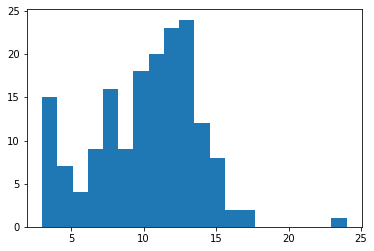

In [33]:
#plt.hist(len_overview, bins = 30)
plt.hist(len_overview, bins = 20)

In [34]:
short = [ s for s in data['summary'] if len(s.split(' ')) < 4 ]
short

['34 playable characters!!',
 'A time-spanning journey',
 '>An auto-farming game!',
 '>An auto-farming game!',
 '>An auto-farming game!',
 'Prison Escape Simulator']

In [35]:
vec_tfidf = TfidfVectorizer(min_df = 2, max_df=0.9, stop_words='english')
vec_overview = vec_tfidf.fit_transform(data['summary'])

In [36]:
def findGame(q, k):
    print(data['summary'][q])
    vals = cosine_similarity(vec_overview[q], vec_overview)
    idx_asc = vals.argsort()[0][-k:] #get index of highest sim values
    idx_dsc = idx_asc[::-1]
    print(idx_dsc)
    flatv = np.sort(vals[0])
    vk_asc = flatv[-k:]
    vk_dsc = vk_asc[::-1] #reverse the list
    if(vk_dsc[0]==0):
        print("No similar game is found")
    else:
        for v, i in zip(vk_dsc, idx_dsc):
            print(str(v)+"\t"+data['summary'][i])

In [37]:
findGame(10, 5)
#100, 1000

Rule is Simple: Don't Get Your Brain Eaten!
[ 10 165 169  60  59]
1.0	Rule is Simple: Don't Get Your Brain Eaten!
1.0	Raise procrastination to an art form - Engage your brain with Sporcle.
0.0	A fun multiplayer word game. Who can make the highest scoring words?
0.0	Magic tower solitaire card game! Play cute solitaire, build tri tower tripeaks
0.0	Krumit's Tale is a solo card-based dungeon crawler - a follow-up to ‘Meteorfall’
